In [ ]:
%pip install --quiet --upgrade diffusers transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.8 MB/s eta 0:00:00


In [ ]:
# The xformers package is mandatory to be able to create several 768x768 images.
%pip install -q xformers==0.0.16rc425

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 48.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 

# Using Dreamlike Photoreal

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

In [ ]:
model_id = "dreamlike-art/dreamlike-photoreal-2.0"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
prompts = ["Cute Rabbit, Ultra HD, realistic, futuristic, sharp, octane render, photoshopped, photorealistic, soft, pastel, Aesthetic, Magical background",
           "Anime style aesthetic landscape, 90's vintage style, digital art, ultra HD, 8k, photoshopped, sharp focus, surrealism, akira style, detailed line art",
           "Beautiful, abstract art of a human mind, 3D, highly detailed, 8K, aesthetic"]

images = []

In [ ]:
for i, prompt in enumerate(prompts):
    image = pipe(prompt).images[0]
    image.save(f'result_{i}.jpg')
    images.append(image)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

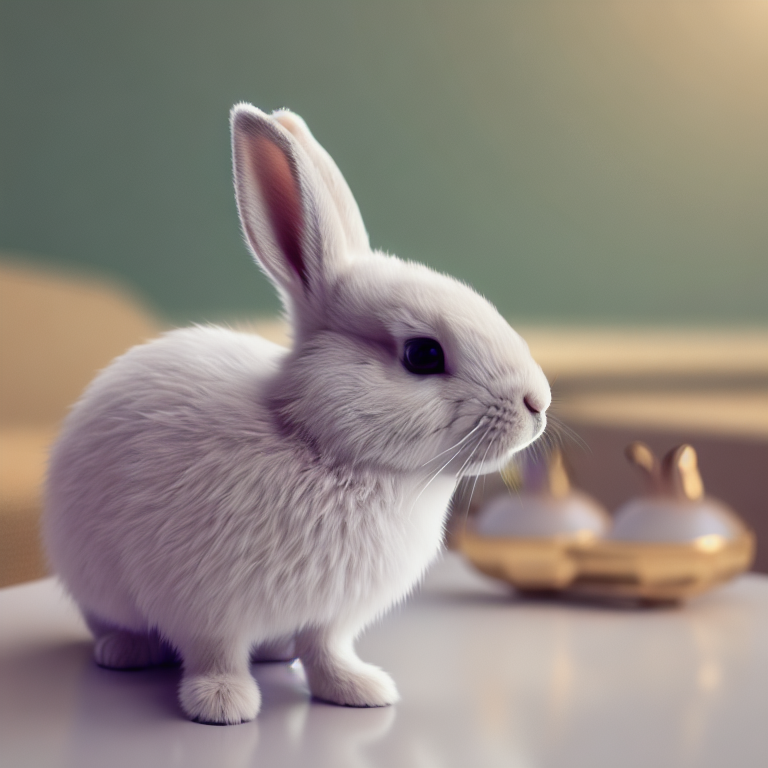

In [ ]:
images[0]

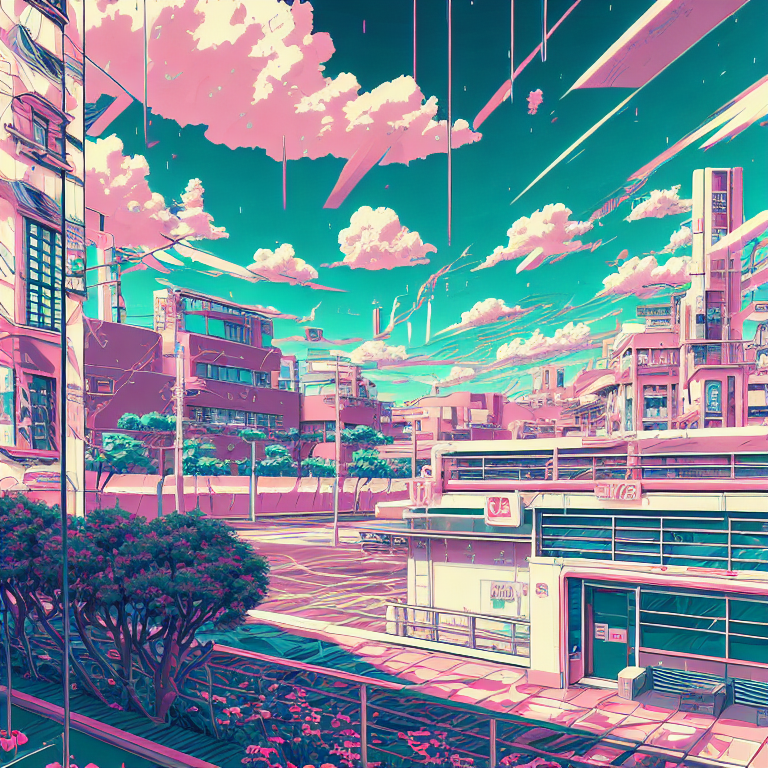

In [ ]:
images[1]

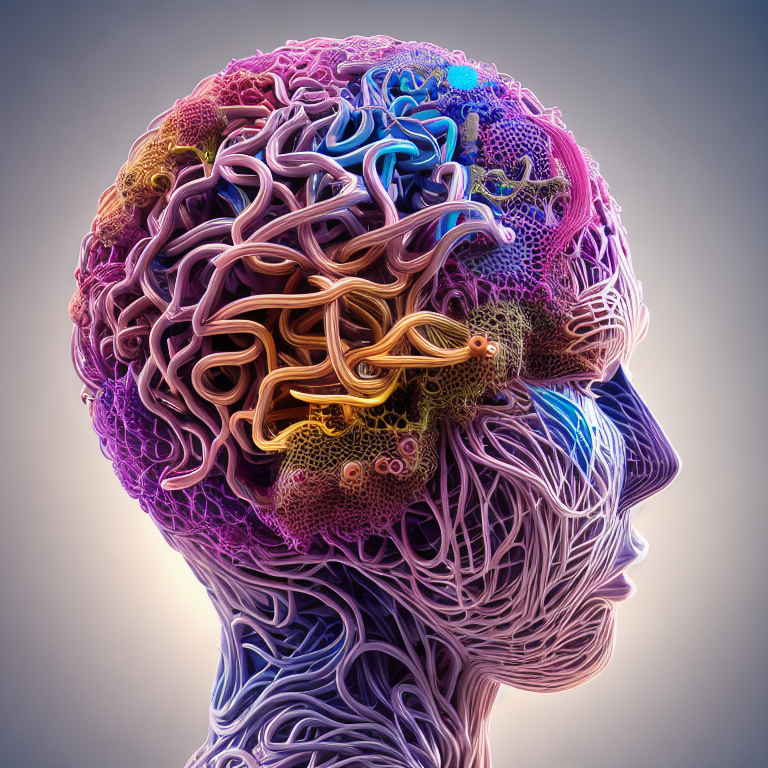

In [ ]:
images[2]

# Manually working with the different components

In [ ]:
import torch
from torch import autocast
import numpy as np

from transformers import CLIPTextModel, CLIPTokenizer

from diffusers import AutoencoderKL
from diffusers import LMSDiscreteScheduler
from diffusers import UNet2DConditionModel
from diffusers.schedulers.scheduling_ddim import DDIMScheduler

from tqdm import tqdm
from PIL import Image

In [ ]:
class ImageDiffusionModel:

    def __init__(self, vae, tokenizer, text_encoder, unet,
                 scheduler_LMS, scheduler_DDIM):
        self.vae = vae
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.unet = unet
        self.scheduler_LMS = scheduler_LMS
        self.scheduler_DDIM = scheduler_DDIM
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'


    def get_text_embeds(self, text):
        # tokenize the text
        text_input = self.tokenizer(text,
                                    padding='max_length',
                                    max_length=tokenizer.model_max_length,
                                    truncation=True,
                                    return_tensors='pt')
        # embed the text
        with torch.no_grad():
            text_embeds = self.text_encoder(text_input.input_ids.to(self.device))[0]

        return text_embeds

    def get_prompt_embeds(self, prompt):
        # get conditional prompt embeddings
        cond_embeds = self.get_text_embeds(prompt)
        # get unconditional prompt embeddings
        uncond_embeds = self.get_text_embeds([''] * len(prompt))
        # concatenate the above 2 embeds
        prompt_embeds = torch.cat([uncond_embeds, cond_embeds])
        return prompt_embeds

    def get_img_latents(self,
                        text_embeds,
                        height=512, width=512,
                        num_inference_steps=50,
                        guidance_scale=7.5,
                        img_latents=None):
        # if no image latent is passed, start reverse diffusion with random noise
        if img_latents is None:
            img_latents = torch.randn((text_embeds.shape[0] // 2, self.unet.in_channels,\
                                       height // 8, width // 8)).to(self.device)
        # set the number of inference steps for the scheduler
        self.scheduler_LMS.set_timesteps(num_inference_steps)
        # scale the latent embeds
        img_latents = img_latents * self.scheduler_LMS.sigmas[0]
        # use autocast for automatic mixed precision (AMP) inference
        with autocast('cuda'):
            for i, t in tqdm(enumerate(self.scheduler_LMS.timesteps)):
                # do a single forward pass for both the conditional and unconditional latents
                latent_model_input = torch.cat([img_latents] * 2)
                sigma = self.scheduler_LMS.sigmas[i]
                latent_model_input = latent_model_input / ((sigma ** 2 + 1) ** 0.5)

                # predict noise residuals
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeds)['sample']

                # separate predictions for unconditional and conditional outputs
                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                # perform guidance
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

                # remove the noise from the current sample i.e. go from x_t to x_{t-1}
                img_latents = self.scheduler_LMS.step(noise_pred, t, img_latents)['prev_sample']

        return img_latents


    def decode_img_latents(self, img_latents):
        img_latents = img_latents / 0.18215
        with torch.no_grad():
            imgs = self.vae.decode(img_latents)["sample"]
        # load image in the CPU
        imgs = imgs.detach().cpu()
        return imgs



    def transform_imgs(self, imgs):
        # transform images from the range [-1, 1] to [0, 1]
        imgs = (imgs / 2 + 0.5).clamp(0, 1)
        # permute the channels and convert to numpy arrays
        imgs = imgs.permute(0, 2, 3, 1).numpy()
        # scale images to the range [0, 255] and convert to int
        imgs = (imgs * 255).round().astype('uint8')
        # convert to PIL Image objects
        imgs = [Image.fromarray(img) for img in imgs]
        return imgs



    def prompt_to_img(self,
                      prompts,
                      height=512, width=512,
                      num_inference_steps=50,
                      guidance_scale=7.5,
                      img_latents=None):

        # convert prompt to a list
        if isinstance(prompts, str):
            prompts = [prompts]

        # get prompt embeddings
        text_embeds = self.get_prompt_embeds(prompts)

        # get image embeddings
        img_latents = self.get_img_latents(text_embeds,
                                      height, width,
                                      num_inference_steps,
                                      guidance_scale,
                                      img_latents)
        # decode the image embeddings
        imgs = self.decode_img_latents(img_latents)
        # convert decoded image to suitable PIL Image format
        imgs = self.transform_imgs(imgs)

        return imgs



    def encode_img_latents(self, imgs):
        if not isinstance(imgs, list):
            imgs = [imgs]

        imgs = np.stack([np.array(img) for img in imgs], axis=0)
        # scale images to the range [-1, 1]
        imgs = 2 * ((imgs / 255.0) - 0.5)
        imgs = torch.from_numpy(imgs).float().permute(0, 3, 1, 2)

        # encode images
        img_latents_dist = self.vae.encode(imgs.to(self.device))
        # img_latents = img_latents_dist.sample()
        img_latents = img_latents_dist["latent_dist"].mean.clone()
        # scale images
        img_latents *= 0.18215

        return img_latents


    def get_img_latents_similar(self,
                                img_latents,
                                text_embeds,
                                height=512, width=512,
                                num_inference_steps=50,
                                guidance_scale=7.5,
                                start_step=10):

        # set the number of inference steps for the scheduler
        self.scheduler_DDIM.set_timesteps(num_inference_steps)

        if start_step > 0:
            start_timestep = self.scheduler_DDIM.timesteps[start_step]
            start_timesteps = start_timestep.repeat(img_latents.shape[0]).long()

            noise = torch.randn_like(img_latents)
            img_latents = scheduler_DDIM.add_noise(img_latents, noise, start_timesteps)

        # use autocast for automatic mixed precision (AMP) inference
        with autocast('cuda'):
            for i, t in tqdm(enumerate(self.scheduler_DDIM.timesteps[start_step:])):
                # do a single forward pass for both the conditional and unconditional latents
                latent_model_input = torch.cat([img_latents] * 2)

                # predict noise residuals
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeds)['sample']

                # separate predictions for unconditional and conditional outputs
                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                # perform guidance
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

                # remove the noise from the current sample i.e. go from x_t to x_{t-1}
                img_latents = self.scheduler_DDIM.step(noise_pred, t, img_latents)['prev_sample']

        return img_latents


    def similar_imgs(self,
                     img,
                     prompt,
                     height=512, width=512,
                     num_inference_steps=50,
                     guidance_scale=7.5,
                     start_step=10):

        # get image latents
        img_latents = self.encode_img_latents(img)

        if isinstance(prompt, str):
            prompt = [prompt]

        text_embeds = self.get_prompt_embeds(prompt)

        img_latents = self.get_img_latents_similar(img_latents=img_latents,
                                                   text_embeds=text_embeds,
                                                height=height, width=width,
                                                num_inference_steps=num_inference_steps,
                                                guidance_scale=guidance_scale,
                                                start_step=start_step)

        imgs = self.decode_img_latents(img_latents)
        imgs = self.transform_imgs(imgs)
        # Clear the CUDA cache
        torch.cuda.empty_cache()

        return imgs


In [ ]:
device = 'cuda'

# model_name = "dreamlike-art/dreamlike-photoreal-2.0"
model_name = "CompVis/stable-diffusion-v1-4"
# Load autoencoder
vae = AutoencoderKL.from_pretrained(model_name,
                                    subfolder='vae').to(device)

# Load tokenizer and the text encoder
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(device)

# Load UNet model
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder='unet').to(device)

# Load scheduler
scheduler_LMS = LMSDiscreteScheduler(beta_start=0.00085,
                                 beta_end=0.012,
                                 beta_schedule='scaled_linear',
                                 num_train_timesteps=1000)

scheduler_DDIM = DDIMScheduler(beta_start=0.00085,
                               beta_end=0.012,
                               beta_schedule='scaled_linear',
                               num_train_timesteps=1000)

In [ ]:
model = ImageDiffusionModel(vae, tokenizer, text_encoder, unet, scheduler_LMS, scheduler_DDIM)

prompts = ["A really giant cute pink barbie doll on the top of Burj Khalifa",
           "A green, scary aesthetic dragon breathing fire near a group of heroic firefighters"]

imgs = model.prompt_to_img(prompts)

0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:244: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(
50it [00:23,  2.10it/s]


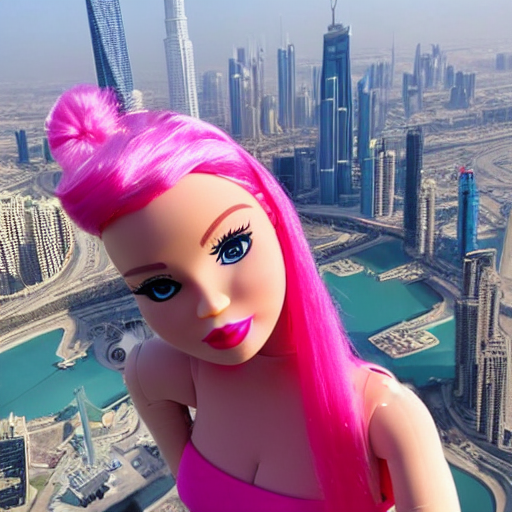

In [ ]:
imgs[0]

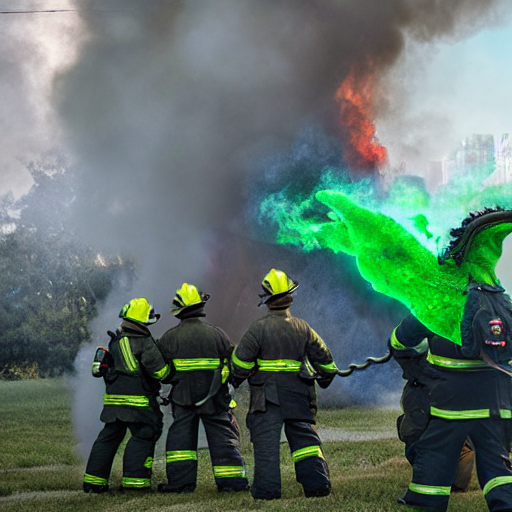

In [ ]:
imgs[1]

0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:244: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(
50it [00:12,  3.97it/s]


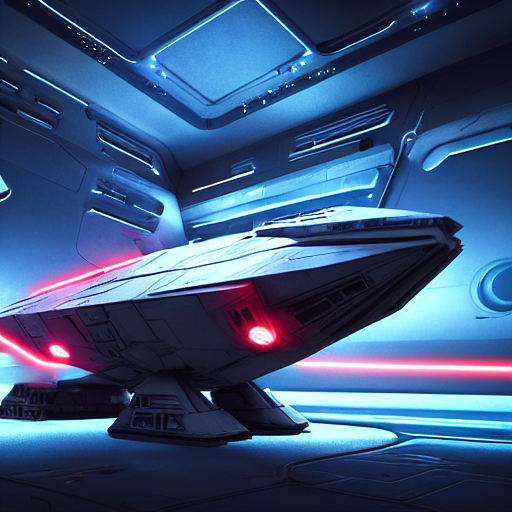

In [ ]:
prompt = ["Aesthetic star wars spaceship with an aethethic background, Ultra HD, futuristic, sharp, octane render, neon"]

imgs = model.prompt_to_img(prompt)

imgs[0]

In [ ]:
# saving the image
imgs[0].save("spaceship1.png")

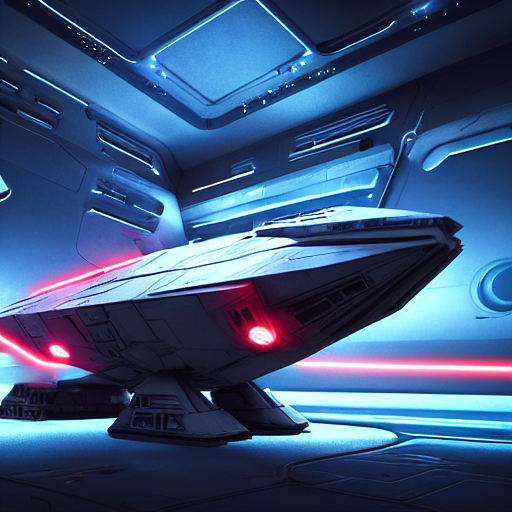

In [ ]:
# loading the image again
original_img = Image.open("spaceship1.png")
original_img

In [ ]:
import torch
import gc

### If you get OOM errors, execute this cell
# del model
# Clear the CUDA cache
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Fri Apr  7 13:37:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   8715MiB / 15360MiB |     81%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

20it [00:04,  4.00it/s]


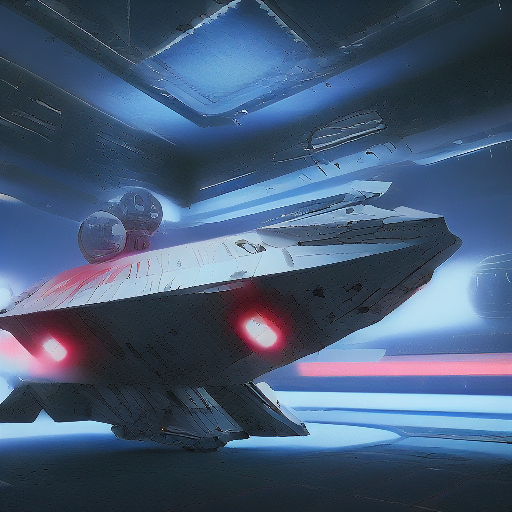

In [ ]:
model = ImageDiffusionModel(vae, tokenizer, text_encoder, unet, scheduler_LMS, scheduler_DDIM)

prompt = "Aesthetic star wars spaceship with an aethethic background, Ultra HD, futuristic, sharp, octane render, neon"

imgs = model.similar_imgs(original_img, prompt, num_inference_steps=50, start_step=30)
imgs[0]

10it [00:02,  4.12it/s]


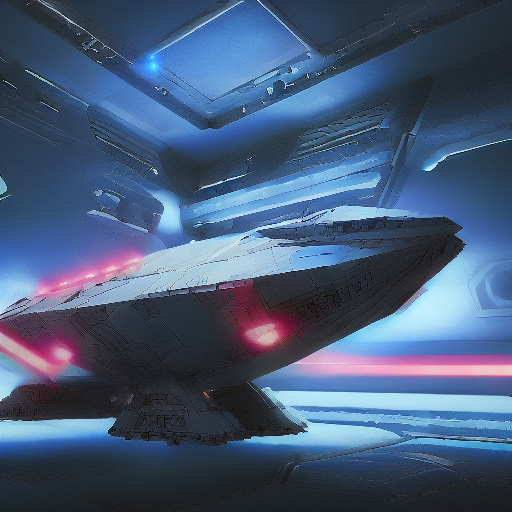

In [ ]:
# model = ImageDiffusionModel(vae, tokenizer, text_encoder, unet, scheduler_LMS, scheduler_DDIM)

prompt = "Aesthetic dark star wars spaceship, Ultra HD, futuristic, sharp, octane render, neon"

imgs = model.similar_imgs(original_img, prompt,
                          num_inference_steps=50,
                          start_step=40)
imgs[0]